# A4: Common Analysis
Patrick Peng (ID: 2029888)  
DATA 512, Autumn 2021

Assigned county: Milwaukee County, Wisconsin

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Step 0: Data acquisition

I have already downloaded the raw data on case counts, mask mandates, and mask usage and saved them in the `data` folder. Because this analysis is focused on Milwaukee County, Wisconsin, I will just extract data relevant to this specific county.

First, the confirmed cases dataset:

In [2]:
# Read in the full dataset
case_data_full = pd.read_csv('data/RAW_us_confirmed_cases.csv')

# Filter down to Milwaukee Co only, and melt from wide to long
case_data_mke = case_data_full[(case_data_full['Province_State']=='Wisconsin') & (case_data_full['Admin2']=='Milwaukee')]
case_data_mke = pd.melt(case_data_mke,id_vars=case_data_mke.columns[:11],var_name='Date',value_name='Total Cases')
case_data_mke['Date'] = pd.to_datetime(case_data_mke['Date'])

In [3]:
case_data_mke.head(5)

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,Combined_Key,Date,Total Cases
0,Wisconsin,Milwaukee,84055079,US,USA,840,55079.0,US,43.004861,-87.967332,"Milwaukee, Wisconsin, US",2020-01-22,0
1,Wisconsin,Milwaukee,84055079,US,USA,840,55079.0,US,43.004861,-87.967332,"Milwaukee, Wisconsin, US",2020-01-23,0
2,Wisconsin,Milwaukee,84055079,US,USA,840,55079.0,US,43.004861,-87.967332,"Milwaukee, Wisconsin, US",2020-01-24,0
3,Wisconsin,Milwaukee,84055079,US,USA,840,55079.0,US,43.004861,-87.967332,"Milwaukee, Wisconsin, US",2020-01-25,0
4,Wisconsin,Milwaukee,84055079,US,USA,840,55079.0,US,43.004861,-87.967332,"Milwaukee, Wisconsin, US",2020-01-26,0


We'll note here that the FIPS code for Milwaukee County is 55079. We can use this to filter the NYT mask survey dataset, since it does not include the full name of the county.

Next, the mask mandates dataset.

In [4]:
mandates_full = pd.read_csv('data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
mandates_mke = mandates_full[(mandates_full['State_Tribe_Territory']=='WI') & (mandates_full['County_Name']=='Milwaukee County')]
mandates_mke['date'] = pd.to_datetime(mandates_mke['date'])

<ipython-input-4-7af6377871db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandates_mke['date'] = pd.to_datetime(mandates_mke['date'])


In [5]:
mandates_mke.head(5)

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
820996,WI,Milwaukee County,55,79,2020-04-25,2,NaN,NaN,NaN,NaN
821053,WI,Milwaukee County,55,79,2020-04-22,2,NaN,NaN,NaN,NaN
821083,WI,Milwaukee County,55,79,2020-04-23,2,NaN,NaN,NaN,NaN
821115,WI,Milwaukee County,55,79,2020-04-24,2,NaN,NaN,NaN,NaN
821146,WI,Milwaukee County,55,79,2020-04-10,2,NaN,NaN,NaN,NaN


Finally, the mask usage survey dataset. We should note here that this is a single point-in-time count taken in July 2020.

In [6]:
mask_survey_full = pd.read_csv('data/mask-use-by-county.csv')
mask_survey_mke = mask_survey_full[mask_survey_full['COUNTYFP']==55079]

In [7]:
mask_survey_mke

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
3087,55079,0.053,0.067,0.119,0.264,0.497


## Step 1: Analysis

The common question that you are to answer is:  
*How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 15, 2021?*

Answering this question can be a little tricky - and it will be useful for you all (whole class) to discuss this on Slack. We will also spend some time in class on this discussion. Some of the issues that you probably should consider when conducting your analysis include:
1. What needs to be cleaned and standardized over the three datasets?
2. There is a delay between the time of infection and the time a case is confirmed. Many factors may contribute to such delay. People may not show symptoms right away after infection. It may take a few days for the testing results to become available especially during the early period of the pandemic. Should we model the delay?
3. Masking may simply make it longer to get infected or it may prevent some percentage of infection. How should we consider the effect of a mask?
4. The research question is about how a time series changes. The infection time series is a set of slopes. Therefore the question is about a derivative function. That is, you want to answer a question about the change in slope over time. How can we test the difference in the derivative function?
5. Masking survey data shows probability of compliance in several categories. How can we model different proportions for population compliance?
6. Masking policies varied in their implementation (e.g., size of “crowd” required, different situations, restaurants, bars, clubs ...). How should I handle things when my County implemented two different policies at different times?
7. The County I was assigned did not implement a masking policy! What is a reasonable way to answer this question? That is, how might I model “voluntary” masking?
8. Vaccinations probably impacted the apparent effectiveness of masks. How should we account for different vaccination rates in different populations within the same County?


[Wikipedia](https://en.wikipedia.org/wiki/Infection_rate) defines infection rate as:  

$$
\frac{\text{number of infections}}{\text{number at risk for infection}}
$$

To calculate this, we need to know how many active infections there are at any given day, and how many people there are at risk of infection. We have to make some simplifying assumptions here. I am going to assume that:
* It takes 7 days for symptoms to show (the actual number is typically somewhere between 2 and 14 days), and therefore this is the delay between the time an infection occurs and the time that it shows up as a confirmed case
* It takes 14 days to recover from COVID after symptoms first appear (based on quarantining guidelines)
* Infected people are contagious for the entire duration of their infection
* Everybody recovers
* There are no reinfections

The number of active infections on any given day will be the cumulative number of infections minus the cumulative number of recoveries. There will be a 7 day reporting lag between this and the official daily new case count.

The number at risk for infection will be the 2020 Census population of Milwaukee County minus the number of recovered infections.


In [8]:
# Calculate daily new cases
case_data_mke['Daily New Cases'] = case_data_mke['Total Cases'].diff()

# Calculate 7-day moving average of daily new cases to smooth out day-to-day volatility
# h/t to Grant Savage for the suggestion on Slack
case_data_mke['Daily New Cases 7d Avg'] = case_data_mke['Daily New Cases'].rolling(window=7).mean().round()

# Per wikipedia, infection rate = (number of infections)/(number at risk of infection)
symptom_lag = 7
recovery_lag = 14

# Number of new infections (-7 day offset from Daily New Cases)
case_data_mke['New Infections'] = case_data_mke['Daily New Cases 7d Avg'].shift(periods=-1*symptom_lag)

# Cumulative new infections
case_data_mke['Cumulative Infections'] = case_data_mke['New Infections'].cumsum()

# Number of recoveries (+14 day offset from Daily New Cases)
case_data_mke['New Recoveries'] = case_data_mke['Daily New Cases 7d Avg'].shift(periods=recovery_lag)
case_data_mke['New Recoveries'] = case_data_mke['New Recoveries'].fillna(value=0)

# Cumulative recoveries
case_data_mke['Cumulative Recoveries'] = case_data_mke['New Recoveries'].cumsum()

# Active infections
case_data_mke['Active Infections'] = case_data_mke['Cumulative Infections'] - case_data_mke['Cumulative Recoveries']

# Calculate population at risk of infection (assume no reinfections can occur)
# Will use total population of Milwaukee Co minus the cumulative number of infections

mke_pop = 939489
case_data_mke['At Risk'] = mke_pop - case_data_mke['Cumulative Infections']

# Infection Rate
case_data_mke['Infection Rate'] = (case_data_mke['Active Infections']/case_data_mke['At Risk'])

# d(Infection Rate)/dT
case_data_mke['Change in Infection Rate'] = (case_data_mke['Infection Rate'].diff())#.rolling(window=7).mean()


In [9]:
case_data_mke['Date'].head(10)

0   2020-01-22
1   2020-01-23
2   2020-01-24
3   2020-01-25
4   2020-01-26
5   2020-01-27
6   2020-01-28
7   2020-01-29
8   2020-01-30
9   2020-01-31
Name: Date, dtype: datetime64[ns]

In [10]:
case_data_mke.dropna(inplace=True)

In [11]:
case_data_mke2 = case_data_mke[['Date','Total Cases','Daily New Cases 7d Avg','Infection Rate','Change in Infection Rate']]
case_data_mke2.set_index('Date',drop=True,inplace=True)

In [12]:
case_data_mke2

,Total Cases,Daily New Cases 7d Avg,Infection Rate,Change in Infection Rate
Date,,,,
2020-01-29,0,0.0,0.000000,0.000000
2020-01-30,0,0.0,0.000000,0.000000
2020-01-31,0,0.0,0.000000,0.000000
2020-02-01,0,0.0,0.000000,0.000000
2020-02-02,0,0.0,0.000000,0.000000
...,...,...,...,...
2021-10-18,149208,300.0,0.008811,-0.000197
2021-10-19,149349,275.0,0.008536,-0.000275
2021-10-20,149598,263.0,0.008267,-0.000269


In [13]:
mandates_mke2 = mandates_mke[['date','Face_Masks_Required_in_Public']]
mandates_mke2.set_index('date',drop=True,inplace=True)

In [14]:
combined_data = case_data_mke2.join(mandates_mke2,on=None,how='left')

In [15]:
combined_data['Face_Masks_Required_in_Public'] = combined_data['Face_Masks_Required_in_Public'].fillna(value='No')

In [16]:
combined_data['Face_Masks_Required_in_Public'][combined_data['Face_Masks_Required_in_Public']=='No'] = 0
combined_data['Face_Masks_Required_in_Public'][combined_data['Face_Masks_Required_in_Public']=='Yes'] = 1

<ipython-input-16-7078d33ec546>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['Face_Masks_Required_in_Public'][combined_data['Face_Masks_Required_in_Public']=='No'] = 0
<ipython-input-16-7078d33ec546>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['Face_Masks_Required_in_Public'][combined_data['Face_Masks_Required_in_Public']=='Yes'] = 1


In [17]:
combined_data.head(5)

,Total Cases,Daily New Cases 7d Avg,Infection Rate,Change in Infection Rate,Face_Masks_Required_in_Public
Date,,,,,
2020-01-29,0,0.0,0.0,0.0,0
2020-01-30,0,0.0,0.0,0.0,0
2020-01-31,0,0.0,0.0,0.0,0
2020-02-01,0,0.0,0.0,0.0,0
2020-02-02,0,0.0,0.0,0.0,0


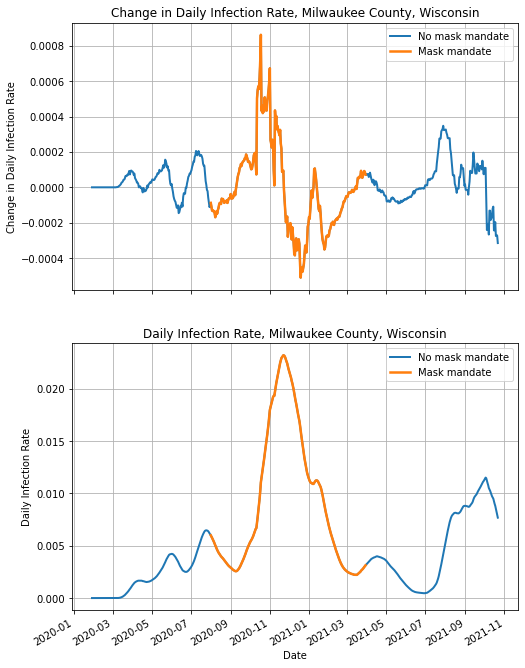

In [84]:
#fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)

x = combined_data.index.to_numpy()
y1 = combined_data['Infection Rate'].to_numpy()
y2 = combined_data['Change in Infection Rate'].to_numpy()
c = combined_data['Face_Masks_Required_in_Public'].to_numpy()

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(x,y2,linewidth=2)
ax1.plot(x[c==1],y2[c==1],linewidth=2.5)
ax1.set_title('Change in Daily Infection Rate, Milwaukee County, Wisconsin')
ax1.set_ylabel('Change in Daily Infection Rate')
ax1.set_xlabel('Date')
ax1.legend(['No mask mandate','Mask mandate'])
ax1.grid(b=True)

ax2.plot(x,y1,linewidth=2)
ax2.plot(x[c==1],y1[c==1],linewidth=2.5)
ax2.set_title('Daily Infection Rate, Milwaukee County, Wisconsin')
ax2.set_ylabel('Daily Infection Rate')
ax2.set_xlabel('Date')
ax2.legend(['No mask mandate','Mask mandate'])
ax2.grid(b=True)

fig.set_size_inches(8,12)
fig.autofmt_xdate()

In [171]:
def get_coeff(start_date,end_date):
    mask = (combined_data.index >= start_date) & (combined_data.index <= end_date)
    df = combined_data.loc[mask]
    ir = df['Infection Rate'].to_numpy()
    x = np.arange(len(ir))
    coeffs = np.polyfit(x, np.log(ir), 1)
    #print(coeffs[0])
    fig,ax = plt.subplots()
    ax.scatter(x,ir)
    ax.plot(x,np.exp(coeffs[1])*np.exp(coeffs[0]*x))
    #ax.legend(['Actual','Fit'])
    plt.show()
    return(coeffs[0])

Initial wave of infections in March 2020. Test availability is not yet widespread.

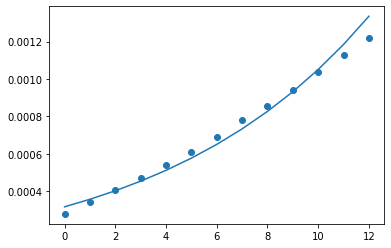

0.11988668801387477

In [225]:
get_coeff('2020-03-20','2020-04-01')

Continuation of initial wave

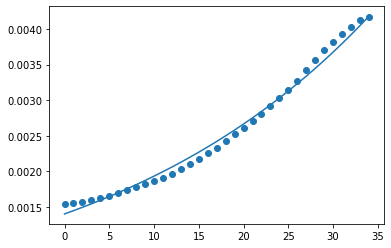

0.03214343630890934

In [204]:
get_coeff('2020-04-25','2020-05-29')

Second wave of infections in summer 2020. Tests were pretty easy to get by now.

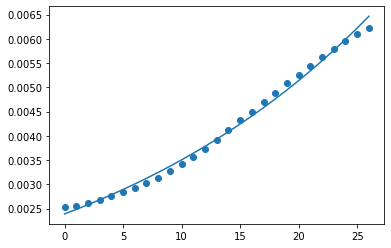

0.03827072068777615

In [203]:
get_coeff('2020-06-25','2020-07-21')

Third wave of infections in fall 2020

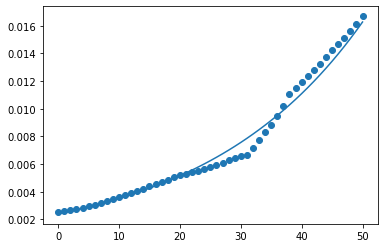

0.038294842868225674

In [201]:
get_coeff('2020-09-10','2020-10-30')

Continuation of third wave of infections in fall 2020

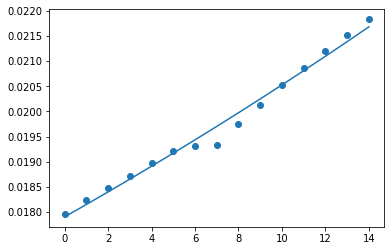

0.01370492108678027

In [208]:
get_coeff('2020-11-01','2020-11-15')

Fourth wave of infections in spring 2021, prior to mass vaccination and Delta variant

Note that the exponential coeff is smaller here, can we attribute that to the mask mandate?

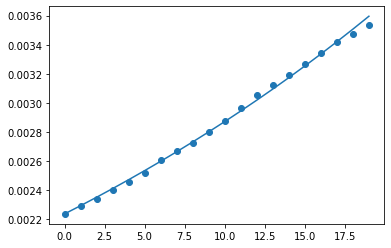

0.024989844633347812

In [209]:
get_coeff('2021-03-17','2021-04-05')

Fifth wave of infections in summer 2021. Delta variant is widespread, people are still getting vaccinated

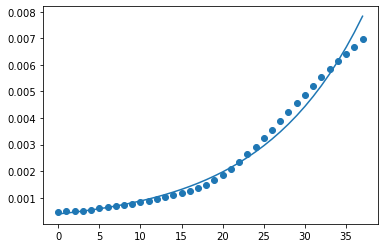

0.08112442739045556

In [217]:
get_coeff('2021-07-01','2021-08-07')

Continuation of previous Delta wave, fall 2021. Vaccination uptake has increased

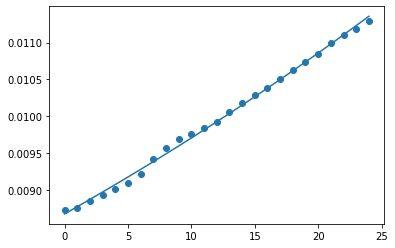

0.011245860202464618

In [219]:
get_coeff('2021-09-07','2021-10-01')